In [24]:
import requests
import pandas as pd
from typing import Dict, List
from dataclasses import dataclass
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
from web3 import Web3

---

In [31]:
@dataclass
class TokenInfo:
    symbol: str
    address: str

@dataclass
class MarketInfo:
    address: str
    factory_address: str
    llamma: str
    rate: float
    total_debt: float
    n_loans: int
    debt_ceiling: float
    borrowable: float
    pending_fees: float
    collected_fees: float
    collateral_amount: float
    collateral_amount_usd: float
    stablecoin_amount: float
    collateral_token: TokenInfo
    stablecoin_token: TokenInfo
    


def fetch_curve_markets(chain: str = "ethereum", page: int = 1, per_page: int = 10) -> Dict:
    """
    Fetch crvUSD market data from Curve API
    """
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}"
    params = {
        "fetch_on_chain": "false",
        "page": page,
        "per_page": per_page
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise exception for bad status codes
    return response.json()

def parse_market_data(market_data: Dict) -> MarketInfo:
    """
    Parse raw market data into MarketInfo object
    """
    
    w3 = Web3()
    
    return MarketInfo(
        address=w3.to_checksum_address(market_data["address"]),
        factory_address=w3.to_checksum_address(market_data["factory_address"]),
        llamma=w3.to_checksum_address(market_data["llamma"]),
        rate=market_data["rate"],
        total_debt=market_data["total_debt"],
        n_loans=market_data["n_loans"],
        debt_ceiling=market_data["debt_ceiling"],
        borrowable=market_data["borrowable"],
        pending_fees=market_data["pending_fees"],
        collected_fees=market_data["collected_fees"],
        collateral_amount=market_data["collateral_amount"],
        collateral_amount_usd=market_data["collateral_amount_usd"],
        stablecoin_amount=market_data["stablecoin_amount"],
        collateral_token=TokenInfo(
            symbol=market_data["collateral_token"]["symbol"],
            address=w3.to_checksum_address(market_data["collateral_token"]["address"])
        ),
        stablecoin_token=TokenInfo(
            symbol=market_data["stablecoin_token"]["symbol"],
            address=w3.to_checksum_address(market_data["stablecoin_token"]["address"])
        )
    )

def get_markets_df() -> pd.DataFrame:
    """
    Fetch market data and return as a pandas DataFrame
    """
    raw_data = fetch_curve_markets()
    markets = [parse_market_data(market) for market in raw_data["data"]]
    
    # Convert to dictionary format suitable for DataFrame
    markets_dict = {
        "address": [],
        "collateral_token": [],
        "rate": [],
        "total_debt": [],
        "n_loans": [],
        "borrowable": [],
        "collateral_amount": [],
        "collateral_amount_usd": [],
        "pending_fees": [],
        "collected_fees": []
    }
    
    for market in markets:
        markets_dict["address"].append(market.address)
        markets_dict["collateral_token"].append(market.collateral_token.symbol)
        markets_dict["rate"].append(market.rate)
        markets_dict["total_debt"].append(market.total_debt)
        markets_dict["n_loans"].append(market.n_loans)
        markets_dict["borrowable"].append(market.borrowable)
        markets_dict["collateral_amount"].append(market.collateral_amount)
        markets_dict["collateral_amount_usd"].append(market.collateral_amount_usd)
        markets_dict["pending_fees"].append(market.pending_fees)
        markets_dict["collected_fees"].append(market.collected_fees)
    
    return pd.DataFrame(markets_dict)

def get_markets_map() -> Dict[str, MarketInfo]:
    """
    Fetch market data and return as a dictionary mapping addresses to MarketInfo objects
    """
    raw_data = fetch_curve_markets()
    markets_map = {}
    
    for market in raw_data["data"]:
        if market["borrowable"] != 0:
            markets_map[market["collateral_token"]["symbol"]] = parse_market_data(market)

    return markets_map


markets = get_markets_map()

In [32]:
markets

{'wstETH': MarketInfo(address='0x100dAa78fC509Db39Ef7D04DE0c1ABD299f4C6CE', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0x37417B2238AA52D0DD2D6252d989E728e8f706e4', rate=0.1789800532787158, total_debt=21401888.156910203, n_loans=83, debt_ceiling=None, borrowable=128626499.69069822, pending_fees=28387.847608418833, collected_fees=6734684.3158310605, collateral_amount=7849.765864548232, collateral_amount_usd=31157447.456845652, stablecoin_amount=0.023573588418711936, collateral_token=TokenInfo(symbol='wstETH', address='0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0'), stablecoin_token=TokenInfo(symbol='crvUSD', address='0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E')),
 'WBTC': MarketInfo(address='0x4e59541306910aD6dC1daC0AC9dFB29bD9F15c67', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0xE0438Eb3703bF871E31Ce639bd351109c88666ea', rate=0.14747491479593955, total_debt=20282208.91658375, n_loans=162, debt_ceiling=None, borrowable=179741067.2816608

In [34]:
def fetch_market_risk_info_df(controller_address: str) -> pd.DataFrame:
    """
    Fetch market risk information from Curve Monitor API and return as DataFrame
    
    Parameters:
    -----------
    controller_address : str
        The controller address to fetch data for
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing market risk information with columns:
        - controller: str
        - blockNumber: int
        - band: int
        - amountBorrowableToken: float
        - amountCollatToken: float
        - oraclePrice: float
        - amountCollatTokenInUsd: float
        - amountFullInBandInUsd: float
        
    Raises:
    -------
    requests.exceptions.RequestException
        If the API request fails
    """
    url = f"https://api.curvemonitor.com/mintMarketRiskInfo/{controller_address}"
    
    response = requests.get(url)
    response.raise_for_status()
    
    # Convert JSON to DataFrame
    df = pd.DataFrame(response.json())
    
    # Convert string numbers to float
    numeric_columns = [
        'amountBorrowableToken',
        'amountCollatToken',
        'oraclePrice',
        'amountCollatTokenInUsd',
        'amountFullInBandInUsd'
    ]
    
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col])
    
    # Sort by blockNumber
    df = df.sort_values('blockNumber', ascending=True)
    
    return df

In [73]:
# Example usage
controller_address = "0xEC0820EfafC41D8943EE8dE495fC9Ba8495B15cf"
fetched_df = fetch_market_risk_info_df(controller_address)


In [74]:
# Get DataFrame info
print(fetched_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 25919 entries, 25918 to 0
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   controller              25919 non-null  object 
 1   blockNumber             25919 non-null  int64  
 2   band                    25919 non-null  int64  
 3   amountBorrowableToken   25919 non-null  float64
 4   amountCollatToken       25919 non-null  float64
 5   oraclePrice             25919 non-null  float64
 6   get_p                   25919 non-null  object 
 7   amountCollatTokenInUsd  25919 non-null  float64
 8   amountFullInBandInUsd   25919 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 2.0+ MB
None


In [75]:
risk_df = fetched_df.copy()


# risk_df["get_p"] = pd.to_numeric(risk_df["get_p"])  # or 
risk_df["get_p"] = risk_df["get_p"].astype(float)
risk_df = risk_df.sort_values(by='blockNumber', ascending=True)
risk_df["crvUSD"] = risk_df["amountBorrowableToken"]
risk_df["collateral"] = risk_df["amountCollatTokenInUsd"]

# If risk_df["crvUSD"] is 0 then make it 1
risk_df.loc[risk_df["crvUSD"] == 0, "crvUSD"] = 0.001

# If risk_df["collateral"] is 0 then make it 1
risk_df.loc[risk_df["collateral"] == 0, "collateral"] = 0.001

risk_df["diff"] = risk_df["get_p"] - risk_df["oraclePrice"]

risk_df["zero"] = 0

risk_df['deviation_product'] = np.where(
    risk_df['diff'] > 0, 
    risk_df['crvUSD'] * risk_df['diff'],
    np.where(
        risk_df['diff'] < 0,
        risk_df['collateral'] * risk_df['diff'],
        0
    )
)


In [76]:
# Sort by blockNumber and get the latest 1/3rd of data
risk_df = risk_df.sort_values('blockNumber', ascending=True)
latest_third_index = len(risk_df) - (len(risk_df) // 3)
recent_df = risk_df.iloc[latest_third_index:].copy()

---

In [77]:
risk_df.describe()

,blockNumber,band,amountBorrowableToken,amountCollatToken,oraclePrice,get_p,amountCollatTokenInUsd,amountFullInBandInUsd,crvUSD,collateral,diff,zero,deviation_product
count,2.591900e+04,25919.000000,25919.000000,25919.000000,25919.000000,25919.000000,25919.000000,25919.000000,25919.000000,25919.000000,25919.000000,25919.0,25919.000000
mean,2.113274e+07,-35.905243,136.452443,0.086919,3326.445155,4517.435460,250.705691,387.158134,136.453390,250.706638,1190.990305,0.0,180.529490
std,1.870579e+05,0.695506,839.089813,0.423782,600.701314,2330.842360,1223.209569,1664.317325,839.089659,1223.209375,1735.983003,0.0,57766.653115
min,2.080876e+07,-36.000000,0.000000,0.000000,2551.209734,1953.344453,0.000000,0.000000,0.001000,0.001000,-597.865282,0.0,-696865.240287
25%,2.097075e+07,-36.000000,0.000000,0.000000,2786.847713,2500.734592,0.000000,0.000000,0.001000,0.001000,-282.578369,0.0,-0.327174
50%,2.113274e+07,-36.000000,0.000000,0.000000,3088.127817,3371.337257,0.000000,0.000000,0.001000,0.001000,285.207529,0.0,0.892065
75%,2.129473e+07,-36.000000,0.000000,0.000000,3838.236800,6178.703276,0.000000,0.000000,0.001000,0.001000,2346.934526,0.0,2.897540
max,2.145671e+07,-24.000000,6376.347137,2.606204,4497.681152,9836.236417,7617.740434,8255.023926,6376.347137,7617.740434,5347.482750,0.0,574108.722088


In [78]:
recent_df.describe()

,blockNumber,band,amountBorrowableToken,amountCollatToken,oraclePrice,get_p,amountCollatTokenInUsd,amountFullInBandInUsd,crvUSD,collateral,diff,zero,deviation_product
count,8.639000e+03,8639.0,8639.0,8639.0,8639.000000,8639.000000,8639.0,8639.0,8.639000e+03,8.639000e+03,8639.000000,8639.0,8639.000000
mean,2.134874e+07,-36.0,0.0,0.0,4073.304792,7433.569290,0.0,0.0,1.000000e-03,1.000000e-03,3360.264498,0.0,3.360264
std,6.235022e+04,0.0,0.0,0.0,252.010391,1315.636377,0.0,0.0,4.337060e-19,4.337060e-19,1064.278513,0.0,1.064279
min,2.124076e+07,-36.0,0.0,0.0,3460.549501,4449.331310,0.0,0.0,1.000000e-03,1.000000e-03,988.781809,0.0,0.988782
25%,2.129475e+07,-36.0,0.0,0.0,3838.419544,6179.490106,0.0,0.0,1.000000e-03,1.000000e-03,2347.906066,0.0,2.347906
50%,2.134874e+07,-36.0,0.0,0.0,4076.921377,7380.159829,0.0,0.0,1.000000e-03,1.000000e-03,3306.551117,0.0,3.306551
75%,2.140273e+07,-36.0,0.0,0.0,4306.090515,8642.377464,0.0,0.0,1.000000e-03,1.000000e-03,4338.538262,0.0,4.338538
max,2.145671e+07,-36.0,0.0,0.0,4497.681152,9836.236417,0.0,0.0,1.000000e-03,1.000000e-03,5347.482750,0.0,5.347483


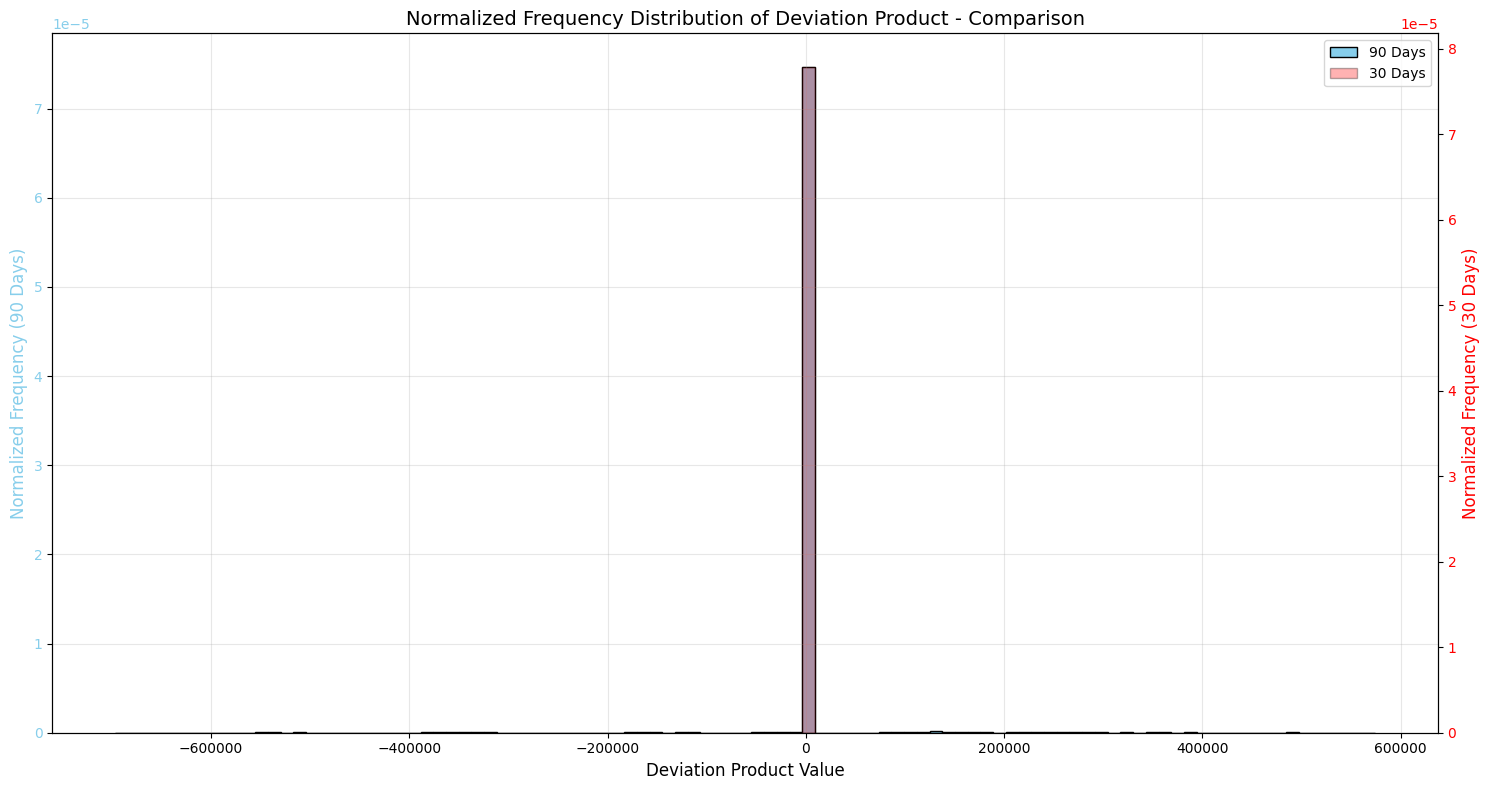

In [79]:
# Create a new figure with a larger size
fig, ax1 = plt.subplots(figsize=(15, 8))

# Calculate bin edges that work for both datasets
min_val = min(risk_df['deviation_product'].min(), recent_df['deviation_product'].min())
max_val = max(risk_df['deviation_product'].max(), recent_df['deviation_product'].max())
bins = np.linspace(min_val, max_val, 100)

# Create histogram for 90 days data on left y-axis
n1, bins1, patches1 = ax1.hist(risk_df['deviation_product'], bins=bins,
                              color='skyblue', alpha=1, edgecolor='black', 
                              label='90 Days', density=True)  # Use density=True to normalize

# Create second y-axis
ax2 = ax1.twinx()

# Create histogram for 7 days data on right y-axis
n2, bins2, patches2 = ax2.hist(recent_df['deviation_product'], bins=bins,
                              color='red', alpha=0.3, edgecolor='black', 
                              label='30 Days', density=True)  # Use density=True to normalize

# Add labels and title
ax1.set_xlabel('Deviation Product Value', fontsize=12)
ax1.set_ylabel('Normalized Frequency (90 Days)', fontsize=12, color='skyblue')
ax2.set_ylabel('Normalized Frequency (30 Days)', fontsize=12, color='red')
plt.title('Normalized Frequency Distribution of Deviation Product - Comparison', fontsize=14)

# Color the tick labels to match the histogram colors
ax1.tick_params(axis='y', labelcolor='skyblue')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend by combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid for better readability
ax1.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [80]:
from scipy import stats
from scipy.stats import gaussian_kde


def analyze_distributions_combined(reference_df, test_df, column='deviation_product', bins=100):
    """
    Analyzes distributions combining both spread analysis and peak location analysis.
    
    Parameters:
    reference_df: DataFrame with reference distribution
    test_df: DataFrame with test distribution
    column: column name to analyze
    bins: number of bins for histogram
    
    Returns:
    dict: Combined analysis results and scores
    """
    # Get data and handle extreme values
    ref_data = reference_df[column].values
    test_data = test_df[column].values
    
    # Handle infinities and NaNs
    def clean_extreme_values(data):
        # Get max value that's not inf
        max_val = np.nanmax(data[~np.isinf(data)])
        min_val = np.nanmin(data[~np.isinf(data)])
        
        # Replace positive infinities with max value
        data = np.where(data == np.inf, max_val, data)
        # Replace negative infinities with min value
        data = np.where(data == -np.inf, min_val, data)
        # Replace NaNs with 0
        data = np.nan_to_num(data, nan=0.0)
        
        return data
    
    ref_data = clean_extreme_values(ref_data)
    test_data = clean_extreme_values(test_data)
    
    # Calculate reference statistics
    ref_std = np.std(ref_data)
    
    # Spread Analysis
    spread_metrics = {
        'reference': {
            'std': np.std(ref_data),
            'iqr': stats.iqr(ref_data),
            'range': np.ptp(ref_data)
        },
        'test': {
            'std': np.std(test_data),
            'iqr': stats.iqr(test_data),
            'range': np.ptp(test_data)
        }
    }
    
    def spread_ratio_score(test_val, ref_val):
        ratio = test_val / ref_val if ref_val != 0 else float('inf')
        
        if ratio <= 1:  # Test spread is tighter than reference
            # Score from 50 to 100 as ratio goes from 1 to 0
            return 50 + (50 * (1 - ratio))
        else:  # Test spread is wider than reference
            # Score from 50 to 0 as ratio goes from 1 to 25
            return max(0, 50 * (25 - ratio) / 24)
    
    spread_score = np.mean([
        spread_ratio_score(spread_metrics['test']['std'], spread_metrics['reference']['std']),
        spread_ratio_score(spread_metrics['test']['iqr'], spread_metrics['reference']['iqr']),
        spread_ratio_score(spread_metrics['test']['range'], spread_metrics['reference']['range'])
    ])
    
    # Peak Analysis
    def find_distribution_peak(data):
        kde = gaussian_kde(data)
        x_range = np.linspace(np.min(data), np.max(data), 1000)
        density = kde(x_range)
        peak_idx = np.argmax(density)
        return x_range[peak_idx]
    
    # def find_distribution_peak(data):
    #    try:
    #        # Add small random noise to prevent singular matrix
    #        noise = np.random.normal(0, 1e-10, len(data))
    #        data_with_noise = data + noise
           
    #        kde = gaussian_kde(data_with_noise)
    #        x_range = np.linspace(np.min(data), np.max(data), 1000)
    #        density = kde(x_range)
    #        peak_idx = np.argmax(density)
    #        return x_range[peak_idx]
    #    except Exception as e:
    #        # Fallback method: use histogram peak if KDE fails
    #        hist, bin_edges = np.histogram(data, bins=bins)
    #        peak_idx = np.argmax(hist)
    #        return (bin_edges[peak_idx] + bin_edges[peak_idx + 1]) / 2
    
    # def find_distribution_peak(data):
    #    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    #    peak_idx = np.argmax(hist)
    #    return (bin_edges[peak_idx] + bin_edges[peak_idx + 1]) / 2
    
    ref_peak = find_distribution_peak(ref_data)
    test_peak = find_distribution_peak(test_data)
    
    # Calculate peak difference in terms of reference standard deviations
    peak_diff_in_stds = abs(test_peak - ref_peak) / ref_std
    peak_score = 100 * np.exp(-peak_diff_in_stds*5)
    
    # Visualization
    fig = plt.figure(figsize=(15, 12))  # Increased height to accommodate new plot
    gs = plt.GridSpec(2, 2, height_ratios=[1, 1])

    # Plot 1: Distribution comparison with KDE (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Plot 2: Box plots for spread comparison (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Plot 3: Zoomed view (bottom)
    ax3 = fig.add_subplot(gs[1, :])  # Span both columns
    
    # Plot 1: Distribution comparison with KDE
    def plot_dist_with_peak(ax, data, label, peak):
        kde = gaussian_kde(data)
        x_range = np.linspace(np.min(data), np.max(data), 1000)
        density = kde(x_range)
        
        ax.hist(data, bins=bins, density=True, alpha=0.3, label=f'{label} Histogram')
        ax.plot(x_range, density, label=f'{label} KDE')
        ax.axvline(x=peak, color='r' if label=='Test' else 'b', 
                  linestyle='--', alpha=0.5,
                  label=f'{label} Peak: {peak:.2e}')
    
    plot_dist_with_peak(ax1, ref_data, 'Reference', ref_peak)
    plot_dist_with_peak(ax1, test_data, 'Test', test_peak)
    ax1.set_title('Distribution Comparison')
    ax1.legend()
    ax1.set_ylabel('Density')
    
    # Plot 2: Box plots for spread comparison
    ax2.boxplot([ref_data, test_data], tick_labels=['Reference', 'Test'])    
    ax2.set_title('Spread Comparison')
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # Plot 3: Zoomed view
    window = 4 * ref_std  # Show ±4 standard deviations around reference peak
    plot_dist_with_peak(ax3, ref_data, 'Reference', ref_peak)
    plot_dist_with_peak(ax3, test_data, 'Test', test_peak)
    ax3.set_xlim(ref_peak - window/2, ref_peak + window/2)
    ax3.set_title('Zoomed View Around Reference Peak')
    ax3.legend()
    ax3.set_xlabel('Value')
    ax3.set_ylabel('Density')
    
    plt.tight_layout()
    
    # Calculate overall score
    overall_score = (spread_score + peak_score) / 2
    
    output_dict = {
        'spread_analysis': {
            'score': spread_score,
            'metrics': spread_metrics
        },
        'peak_analysis': {
            'score': peak_score,
            'metrics': {
                'reference_peak': ref_peak,
                'test_peak': test_peak,
                'difference_in_std_units': peak_diff_in_stds,
                'reference_std': ref_std,
                'absolute_difference': abs(test_peak - ref_peak)
            }
        },
        'overall_score': overall_score
    }
    
    print(json.dumps(output_dict, indent=4))
    
    return output_dict

{
    "spread_analysis": {
        "score": 89.71121886189077,
        "metrics": {
            "reference": {
                "std": 57765.53873546077,
                "iqr": 3.2247141105534896,
                "range": 1270973.9623748476
            },
            "test": {
                "std": 1.064216913816118,
                "iqr": 1.9906321950532546,
                "range": 4.358700940834441
            }
        }
    },
    "peak_analysis": {
        "score": 97.25670525516371,
        "metrics": {
            "reference_peak": 325.68201651074924,
            "test_peak": 4.31779964444213,
            "difference_in_std_units": 0.005563251445433676,
            "reference_std": 57765.53873546077,
            "absolute_difference": 321.3642168663071
        }
    },
    "overall_score": 93.48396205852724
}


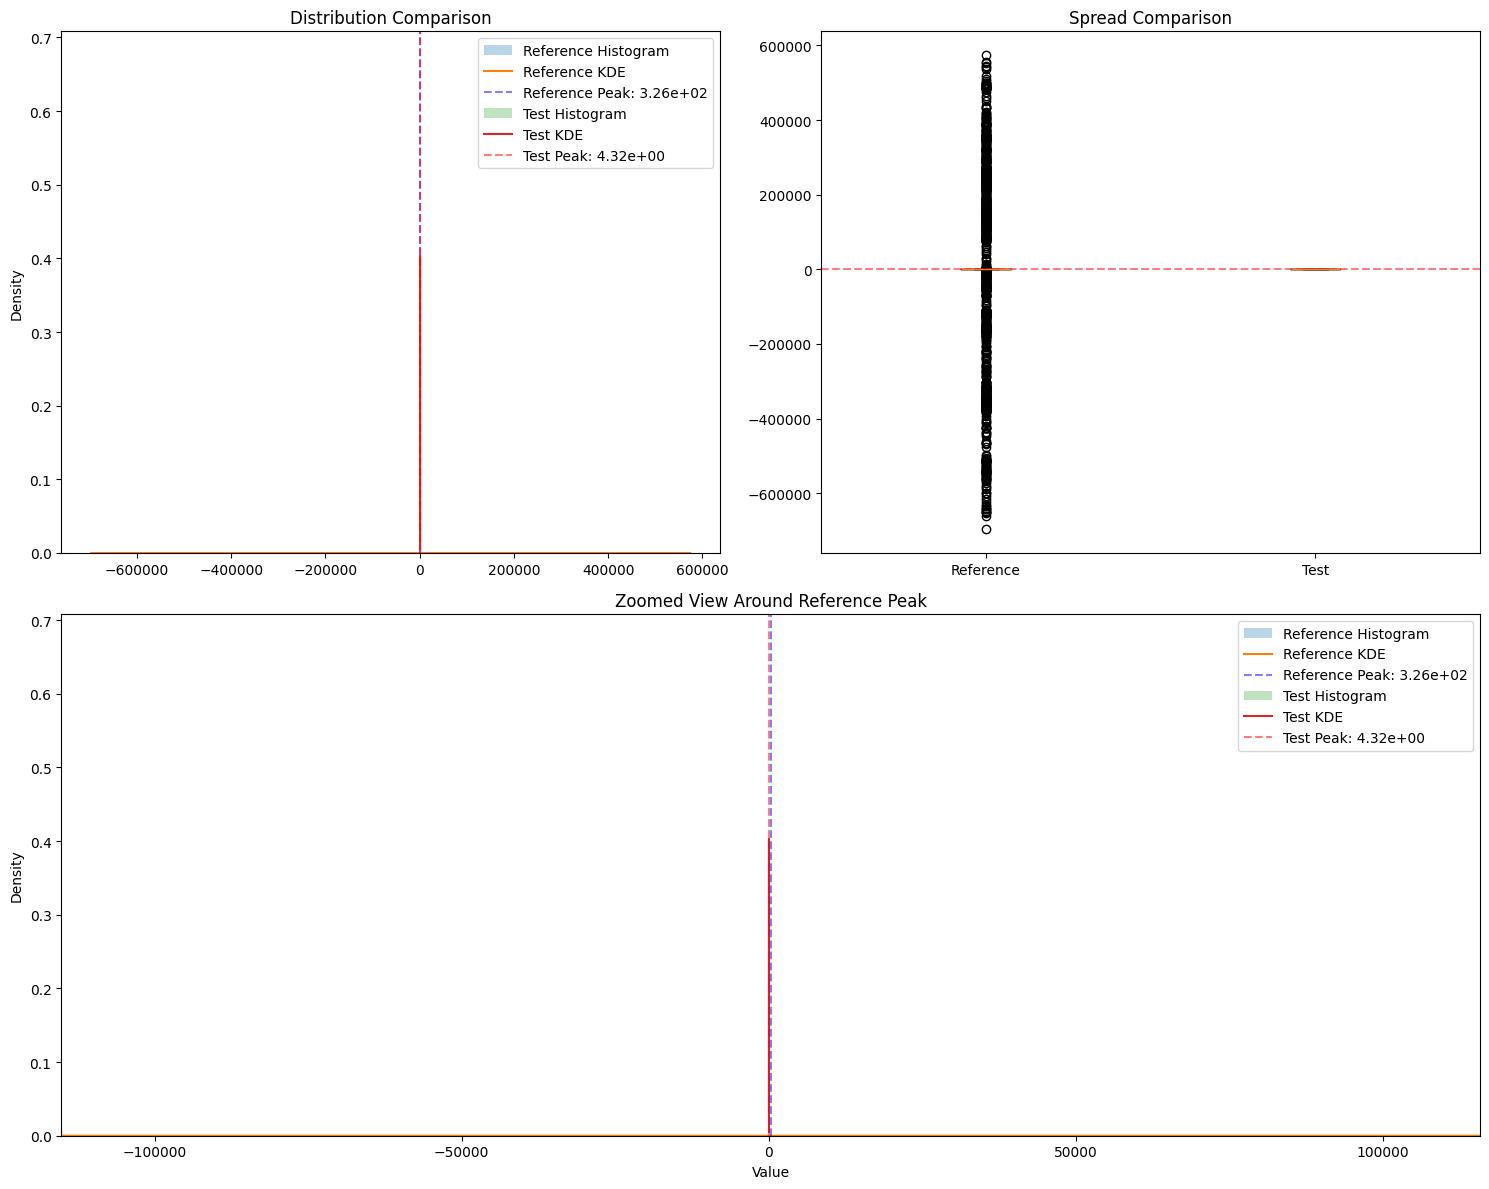

In [81]:
# For the 100% matched data
analysis = analyze_distributions_combined(risk_df, recent_df)